<a href="https://colab.research.google.com/github/jarvez31/Object_representation_model/blob/main/Obj_graph_mlp_catasforge_local2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

### Install the extra modules

In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
tf.test.is_gpu_available()

False

In [29]:
###############------------------- FOR AZRA ---------------------#############

from tensorflow.keras.models import model_from_yaml, model_from_json
from tensorflow import keras
from functions import *
import pickle, shapely
import numpy as np
import math as mt
import tempfile
import tensorflow as tf
import pickle
from scipy import misc
import glob, csv
from tensorflow.keras import layers
from shapely.geometry import box, Polygon, Point, LinearRing
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Reshape, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, concatenate, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 
from keras.regularizers import Regularizer 
# from keras_gcn import GraphConv
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from sklearn import preprocessing
from numpy import linalg as LA
import pandas as pd
from tensorflow.keras.utils import plot_model
from numpy import matlib
from progressbar import ProgressBar
import tensorflow_model_optimization as tfmot
from matplotlib import cm
main = "Bharat_local_runs/"

In [30]:
#@title Setup Parameters
fol1 = "test_wale" #@param {type:"string"}
traj1 = "traj_obj(sh2)_20k.pk1" #@param {type:"string"}
imgs = "frames_traj(col_obj)(sh2)_bw_20k.pk1" #@param {type:"string"}
old_model_n = "train_1" #@param {type:"string"}
# fisher_n = "frames_traj(wo)_bw_20k.pk1" #@param {type:"string"}
new_model_n = "train_3" #@param {type:"string"}
retrain_epochs = 15 #@param {type:"number"}
lam = 20 #@param {type:"number"}
# test_p =  7#@param {type:"number"}
# img_fol = "traj_four_objs_diffW" #@param {type:"string"}

#@markdown ### Standard deviation for population code for x,y
std_dev =  0.1 #@param {type:"slider", min:0, max:1, step:0.1}

#@markdown ### Model Params
Retrain = True #@param {type:"boolean"}
Train = False #@param {type:"boolean"}
Retrain_nocat = False #@param {type:"boolean"}
# Analysis = False #@param {type:"boolean"}
pre_conv = True #@param {type:"boolean"}
obj_pres = True #@param {type:"boolean"}
pi_use = "no_osc" #@param ["osc", "no_osc"]
act_func = "relu" #@param {type:"string"}
learn_rate = 0.001 #@param {type:"number"}
random_state = 42 #@param {type:"number"}

# DATA

### Trajectory

[(-0.55, 0.25, -0.25, 0.55)]
359.9631443233128
20000
20000


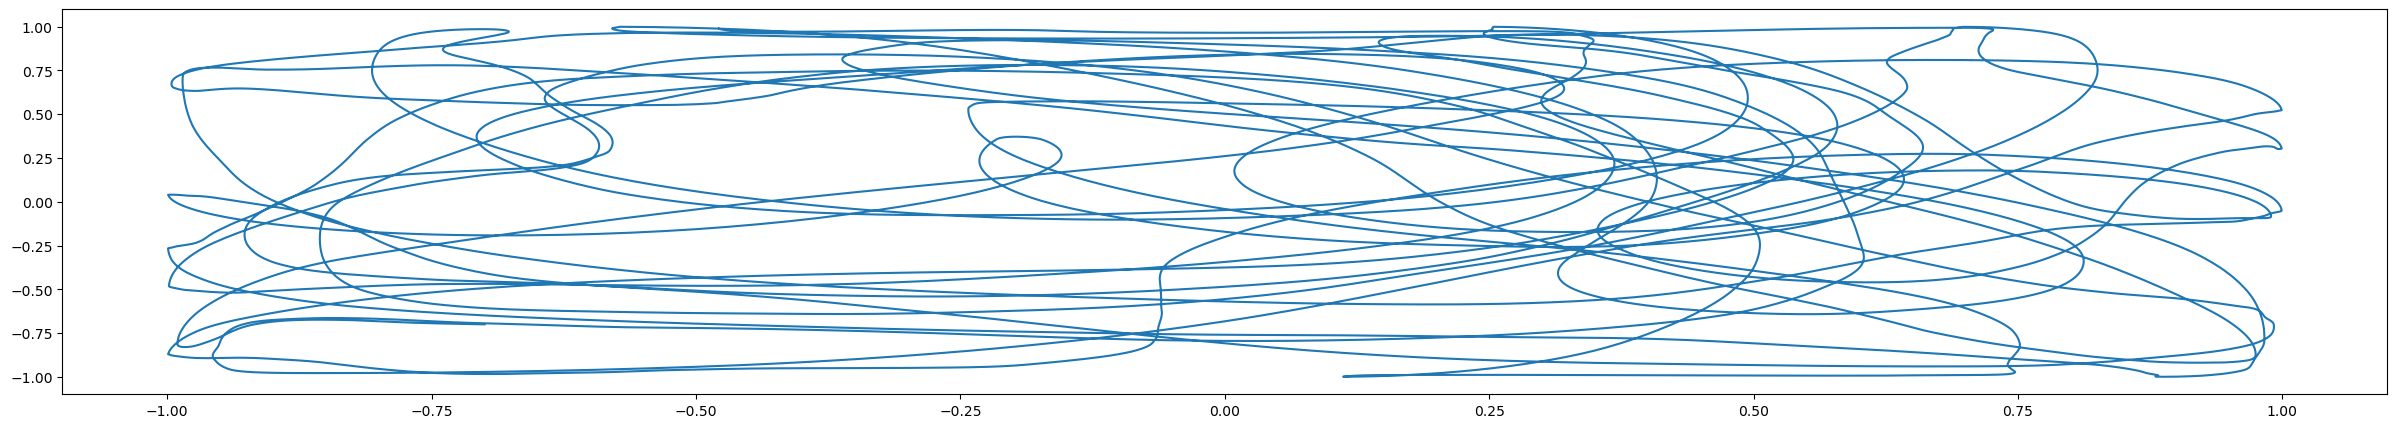

In [31]:
###--------------------- LOAD TRAJECTORY --------------------###

fol = main + fol1 + "/"
traj = traj1
with open(traj, "rb") as f:
    d = pickle.load(f)
    f.close()
locals().update(d)

x = np.asarray(x)
y = np.asarray(y)
pos = np.column_stack((x,y))
# x = x[:-1]
# y = y[:-1]
# theta = theta[:-1]
env = [(1.0, -1.0), (1.0, 1.0), (-1.0, 1.0), (-1.0, -1.0), (1.0, -1.0)]
# obj_c = [(0.4, 0.4)]#, (0.4, 0.4)]
# obj_c_plot = [(-0.4, -0.4), (0.4, 0.4)]#, (-0.4, 0.4)]#, (-0.4, 0.4)]#, (0.4, -0.4), (0.0, 0.0)]
obj_c, obj_c_plot = obj_cent(traj1)

hf_sz = 0.15
out_bound = 0.25
obj_ver = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c]
print(obj_ver)
obj_ver_outer = [(c[0]-hf_sz-out_bound, c[1]-hf_sz-out_bound, c[0]+hf_sz+out_bound, c[1]+hf_sz+out_bound) for c in obj_c]

sq1_env = box(-1.0, -1.0, 1.0, 1.0)
sq1 = box(-0.8, -0.8, 0.8, 0.8)
sq2 = [box(obj_ver[j][0], obj_ver[j][1], obj_ver[j][2], obj_ver[j][3]) for j in range(len(obj_ver))]
sq3 = [box(obj_ver_outer[k][0], obj_ver_outer[k][1], obj_ver_outer[k][2], obj_ver_outer[k][3]) for k in range(len(obj_ver_outer))]
k1_env = list(sq1_env.exterior.coords)
k1 = list(sq1.exterior.coords)
k2 = [list(l.exterior.coords) for l in sq2]
k3 = [list(ll.exterior.coords) for ll in sq3]

env = [[m[0] for m in k1_env ], [m[1] for m in k1_env ]]
obj = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2]
obj_boun = [[[m[0] for m in objbi ], [m[1] for m in objbi ]] for objbi in k3]
# env = np.asarray(env)
# obj = np.asarray(obj)

theta = np.asarray(theta)
theta_rad = np.radians(theta)
print(max(theta))
print(len(theta))

## objects to do plotting that show shifting
obj_ver_plot = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c_plot]
sq2_plot = [box(obj_ver_plot[j][0], obj_ver_plot[j][1], obj_ver_plot[j][2], obj_ver_plot[j][3]) for j in range(len(obj_ver_plot))]
k2_plot = [list(l.exterior.coords) for l in sq2_plot]
obj_plot = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2_plot]

# reward around the object
reward = rew_new(x, y, obj_ver_outer, present = obj_pres)
print(len(reward))
plt.plot(x,y)

### Reward

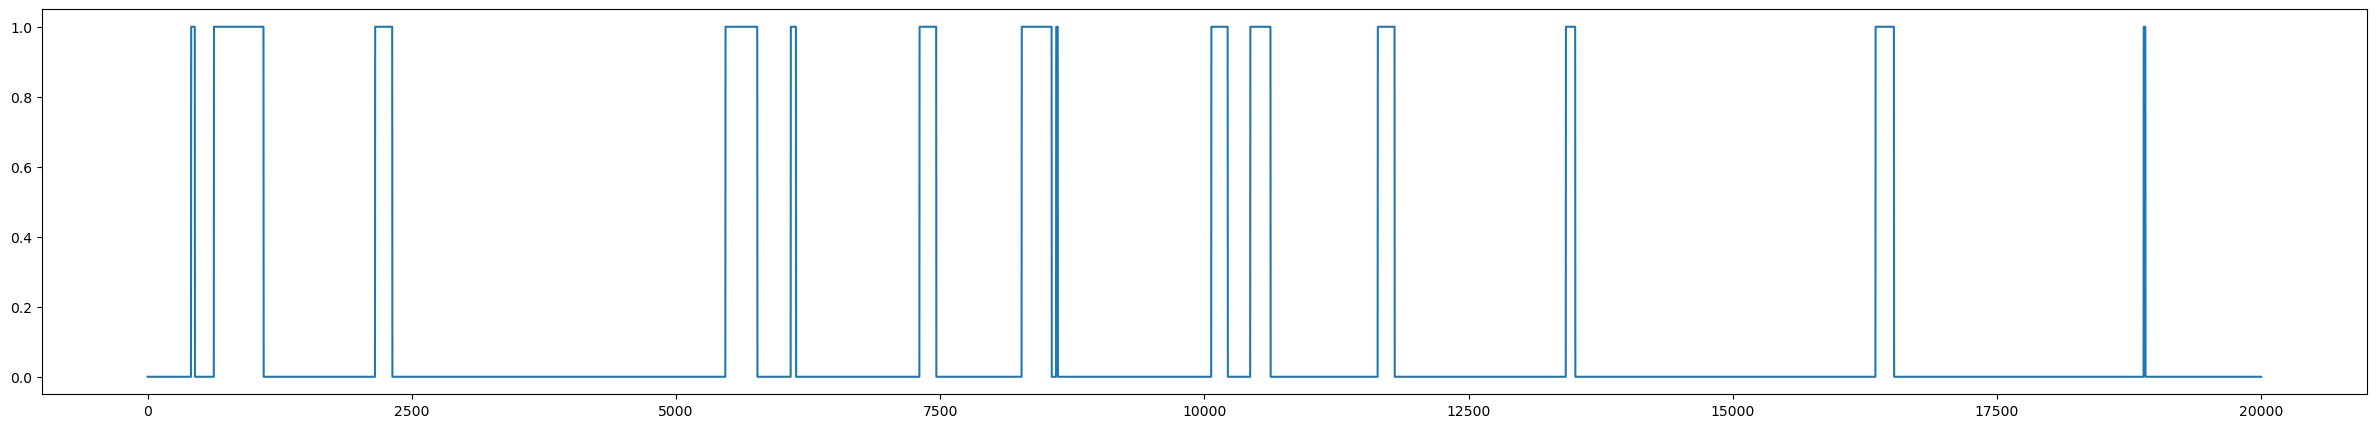

2269
(20000,)


(98.5, -0.5)

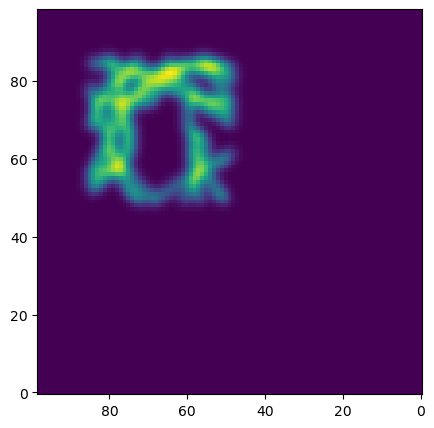

In [32]:
#print(gt)
plt.plot(reward)
plt.show()
from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
#ot = predicted_output[1][:,-1,:]
#ot = gt
# ot = np.ndarray.flatten(encoded['val'])
ot = reward
print(np.sum(reward))
print(ot.shape)
thresh = np.min(ot)*0
# print(thresh)
firr = np.nonzero(ot!=thresh)
# print(firr[0])
#firr = np.nonzero(abs(resp_neurons[i+num])>thresh)
firposgrid = pos[firr[0], :]
# print(firposgrid)
title = "pred reward without object"
firing_map = firing_rate_map(firposgrid, ot, firr, title)
plt.imshow(firing_map, origin= 'upper')
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.set_xlim(ax.get_xlim()[::-1])

### Images

In [33]:
with open(imgs, "rb") as f:
    train_imgs = pickle.load(f)
    f.close()

# train_imgs = train_imgs[:-1]
print(train_imgs.shape)

(20000, 32, 32, 3)


### PI

In [34]:
####--------------------- PI (WITHOUT OSCILLATORS)-------------------########
print(pi_use)
if pi_use == "no_osc":
  #%%Calculating distance from starting point
  print("------using PI WITHOUT oscillators-----")
  pos = np.column_stack((x,y))
  a = pos[0,0] * np.ones(pos[:,0].shape)
  b = pos[0,1] * np.ones(pos[:,1].shape)
  origin = np.transpose(np.append([a],[b],axis=0)) #for different x,y

  #origin = 0 * np.ones(pos.shape) #for same x,y
  disp = pos - origin


  # %% Head direction parameters
  n = 100
  dth = np.divide(2*np.pi, n)
  theta_pref = np.arange(0, 2*np.pi, dth)
  pref_dir = np.transpose([np.cos(theta_pref), np.sin(theta_pref)])
  print(len(pos))
  #curr_dir = []
  #for i in range(len(theta_rad)):
  #    dir = np.repeat(theta_rad[i],100)
  #    curr_dir[i].append(np.cos(dir - theta_pref))
  hdi = preprocessing.normalize(np.cos(np.matlib.repmat(theta_pref, len(pos),1) - np.transpose((np.matlib.repmat(theta_rad[0:len(pos)],n, 1)))), norm='l2')

  #%% HD responses
  hd_resp = []
  for i in range(len(disp)):
      for j in range(len(pref_dir)):
          z = np.array(disp[i])
          dj = np.array(pref_dir[j])
          hd_resp.append(np.dot(z,dj))
  hd_resp = np.transpose(np.reshape(hd_resp, (len(disp),len(pref_dir))))

  #%% path integraion
  #beta = np.transpose(np.random.normal(9,2, size=(1,7)))
  # beta = np.arange(3,4,1)
  beta = [3*np.pi]
  pi_layer_beta = [] 
  for i in range(len(beta)):
      #pi_layer_temp = np.concatenate((np.cos(beta[i] * hd_resp),np.sin(beta[i] * hd_resp)))
      #pi_layer_temp = np.concatenate((beta[i] * hd_resp,beta[i] * hd_resp))
      pi_layer_temp = np.sin(beta[i] * hd_resp)
      #pi_layer_temp = (beta[i]* hd_resp)
      pi_layer_beta.append((pi_layer_temp))
  pi_layer_beta = np.asarray(pi_layer_beta)
  pi_beta = pi_layer_beta[0]
  for i in range(len(beta) - 1):
      pi_beta = np.concatenate((pi_beta, pi_layer_beta[i+1]))
  pi_lay = pi_beta.T
  # sub_pi = test_train(pi, test_p)


##### ---------------------------- PI (WITH OSCILLATORS) ----------------------#########
if pi_use == "osc":
  print("-------- using PI WITH oscillators --------")
  trj_hd_resp = HD(speed, theta)
  #hd = np.asarray(trj_hd_resp)
  PI1d = PI(trj_hd_resp, speed)
  PI1d = np.transpose(PI1d)
  PI1d = preprocessing.normalize(PI1d, norm='l2', axis=1)

  hd_resp = [iii.T.reshape(100,1) for iii in trj_hd_resp]
  hd_resp = np.asarray(hd_resp).reshape(len(hd_resp), hd_resp[0].shape[0])
  hd_resp = preprocessing.normalize(hd_resp, norm='l2', axis=1)
  num_images = PI1d.shape[0]
  # d = {"CAdns1":CAdns1, "CAdns2":CAdns2, "PIdns1": PIdns1, "PIdns2":PIdns2, "Lecdns":Lecdns}
  # with open(fol+"PI.pk1", 'wb') as ff:
  #     pickle.dump(PI1d, ff)
  #     ff.close()

  # with open(fol + "PI.pk1", "rb") as f:
  #     PI1d = pickle.load(f)
  #     f.close()

  pi_lay = PI1d
  # sub_pi = test_train(pi, test_p)
# pi = pi[:-1]
# from sklearn.model_selection import train_test_split

# sub_imgs = train_test_split(train_imgs, test_size=0.2, random_state=random_state)
# sub_pi = train_test_split(pi, test_size=0.2, random_state=random_state)
# sub_comp_gt = train_test_split(comp_gt, test_size=0.2, random_state=random_state)
# sub_r = train_test_split(reward, test_size=0.2, random_state=random_state)
# print(sub_imgs[0].shape, sub_pi[0].shape, sub_comp_gt[0].shape, sub_r[0].shape)

no_osc
------using PI WITHOUT oscillators-----
20000


---------------------------------
---------------------------------
---------------------------------
### Test train split

In [35]:
# GENERATING DATA FOR LSTM
from sklearn.model_selection import train_test_split
seq_len = 1

pi_seq = seq_data(pi_lay, seq_len)
train_imgs_seq = seq_data(train_imgs, seq_len)
r_seq = seq_data(reward, seq_len)
print(train_imgs_seq.shape)

# sub_imgs_seq = train_test_split(train_imgs_seq, test_size=0.2, random_state=random_state)
# sub_pi_seq = train_test_split(pi_seq, test_size=0.2, random_state=random_state)
# sub_r_seq = train_test_split(r_seq, test_size=0.2, random_state=random_state)
sub_imgs = train_test_split(train_imgs, test_size=0.2, random_state=random_state)
sub_pi = train_test_split(pi_lay, test_size=0.2, random_state=random_state)
sub_r = train_test_split(reward, test_size=0.2, random_state=random_state)

# sub_comp_gt = train_test_split(comp_gt[:-1], test_size=0.2, random_state=random_state)

sub_pi_t = sub_pi
sub_imgs_t = sub_imgs
sub_r_t = sub_r
comp_data = [train_imgs, pi_lay]

print(sub_pi_t[0].shape, sub_pi_t[1].shape)
print(sub_imgs_t[0].shape, sub_imgs_t[1].shape)
# print(sub_comp_gt[0].shape, sub_comp_gt[1].shape)
print(sub_r_t[0].shape, sub_r_t[1].shape)

(19999, 1, 32, 32, 3)
(16000, 100) (4000, 100)
(16000, 32, 32, 3) (4000, 32, 32, 3)
(16000,) (4000,)


# MODEL

### Setup Architecture

In [36]:
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.constraints import max_norm

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learn_rate,
    decay_steps=10000,
    decay_rate=0.98,
    staircase=True)

def model_arch():
  print("#########-----------------TRAINING MODEL---------------#########")
  act = 'relu'
  input_img = Input(shape=(32, 32, 3), name="IMAGE")
  input_pi = Input(shape = pi_lay.shape[1], name="PI")

  encoder = Conv2D(8, (5, 5), padding='same', activation= act, name="CONV_1")(input_img)
  encoder = MaxPooling2D(pool_size=(2,2), padding='same', name="MAXPOOL_1")(encoder)
  encoder = Conv2D(4, (5, 5), padding='same', activation= act,name="CONV_2")(encoder)
  encoder = MaxPooling2D(pool_size=(2,2), padding='same', name="MAXPOOL_2")(encoder)
  encoder = Conv2D(2, (5, 5), padding='same', activation= act,name="CONV_3")(encoder)
  encoder = MaxPooling2D(pool_size=(2,2), padding='same', name="MAXPOOL_3")(encoder)
  flatencoder=Flatten()(encoder) 
  #flatencoder = GlobalAveragePooling2D()(encoder)
  dense0 = Dense(100, activation = 'sigmoid', name='LEC')(flatencoder)
  # dense1 = Dense(50, activation = act, name='LEC2')(dense0)
  # dense0 = Dropout(0.5)(dense0)
  dense_pi1 = Dense(100, activation= 'sigmoid', name='MEC')(input_pi)
  # dense_pi2 = Dense(50, activation= act, name='MEC2')(dense_pi1)
  # concat = layers.concatenate([dense1, dense_pi2])
  dense_pi1 = layers.Reshape((1,100))(dense_pi1)
  dense0 = layers.Reshape((1,100))(dense0)
  data_layer = layers.concatenate([dense0, dense_pi1], axis=1)
  print(data_layer.shape)
  # edge_layer = layers.Input(shape=(None, None))
  edge_layer = tf.constant(np.matlib.repmat(np.asarray([[1/3,1/3], [1/3,1/3]]), 1, 1).reshape((1,2,2)))
  # edge_layer = tf.constant(np.asarray([[0,1], [1,0.]]).reshape((1,2,2)))
  conv_layer = GraphConv(units=100, step_num=1)([data_layer, edge_layer])
  # conv_layer = Dropout(0.5)(conv_layer)
  # conv_layer0 = layers.Add()([conv_layer[:,0,:],conv_layer[:,1,:]]) 
  conv_layer0 = Flatten()(conv_layer) 
  dense1 = Dense(100, activation = 'sigmoid', name = 'D1')(conv_layer0)
  dense2 = Dense(100, activation = 'sigmoid', name = 'D2')(dense1)
  dense3 = Dense(100, activation = 'sigmoid', name = 'D3')(dense2)
  # dense4 = Dense(50, activation=act, name = 'D4')(dense3)

  output1 = Dense(1, activation='linear', name='VALUE1')(dense3)
  # output2 = Dense(1, activation='linear', name='VALUE2')(conv_layer[:,1,:])
  #%%
  regressor_model = Model([input_img, input_pi], output1)
  #regressor_model = Model([input_img,], [outputx, outputy, outputz])
  opt = tf.keras.optimizers.Adam(learning_rate= lr_schedule)
  regressor_model.compile(optimizer=opt, loss="mse", )
  regressor_model.summary()

  return regressor_model

### Train the model

In [37]:
# Train the model 
if Train:
  tf.keras.backend.clear_session()
  model = model_arch()
  num_images = pos[0]-1

  history = model.fit(
            [sub_imgs_t[0], sub_pi_t[0]],
            sub_r_t[0],
            epochs = 10,
            batch_size = 16,
            validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_r_t[1]),
            shuffle = True)
  
  namm = new_model_n
  model.save(fol+ namm +".h5")
  
  wts = model.weights
  print(wts[-1])

  img_ind = np.where(sub_r_t[0] == 1)

  print('Processing Fisher Information...')
  I_new = computer_fisher(model, [sub_imgs_t[0], sub_pi_t[0]], img_ind[0])
  print('Processing Finish!')
  hist_ = history.history
  
  # I_new = New_I.copy()
  New_I = I_new.copy()
  for j in range(len(New_I)):
    if np.amax(New_I[j]) == 0:
      New_I[j] = New_I[j]/(np.amax(New_I[j]) + 0.00001)
    else:
      New_I[j] = New_I[j]/np.amax(New_I[j])
      
  model_dict = {"weights": wts, "fisher": I_new, "history": hist_} 
  with open(fol+"mod_dict_" + namm + ".pk1", 'wb') as ff:
      pickle.dump(model_dict, ff)
      ff.close()

  # with open(fol+"hist_" + namm + ".pk1", 'wb') as ff:
  #     pickle.dump(hist_, ff)
  #     ff.close()

  kk = str(len(pos))
  plt.plot(hist_["loss"], "-r", label = "loss")
  plt.plot(hist_["val_loss"], "--b", label = "val_loss")
  plt.legend()
  plt.title("training 1 without objects "+kk)
  plt.show()

### Retrain The model

In [38]:
if Retrain:

  tf.keras.backend.clear_session()
  # del old_model
  with open(fol+"mod_dict_" + old_model_n + ".pk1", "rb") as f:
      old_mod_dict = pickle.load(f)
      f.close()

  old_wts = old_mod_dict["weights"]
  I = old_mod_dict["fisher"]

  print("#########-----------------RETRAINING MODEL---------------#########")
  act = 'relu'
  input_img = Input(shape=(32, 32, 3), name="IMAGE")
  input_pi = Input(shape = pi_lay.shape[1], name="PI")

  encoder = Conv2D(8, (5, 5), padding='same', activation= act, name="CONV_1", kernel_regularizer=ewc_reg(I[0], old_wts[0], Lambda = lam),
                   bias_regularizer = ewc_reg(I[1], old_wts[1], Lambda = lam))(input_img)
  encoder = MaxPooling2D(pool_size=(2,2), padding='same', name="MAXPOOL_1")(encoder)
  encoder = Conv2D(4, (5, 5), padding='same', activation= act, name="CONV_2", kernel_regularizer=ewc_reg(I[2], old_wts[2], Lambda = lam),
                   bias_regularizer = ewc_reg(I[3], old_wts[3], Lambda = lam))(encoder)
  encoder = MaxPooling2D(pool_size=(2,2), padding='same', name="MAXPOOL_2")(encoder)
  encoder = Conv2D(2, (5, 5), padding='same', activation= act, name="CONV_3", kernel_regularizer=ewc_reg(I[4], old_wts[4], Lambda = lam),
                   bias_regularizer = ewc_reg(I[5], old_wts[5], Lambda = lam))(encoder)
  encoder = MaxPooling2D(pool_size=(2,2), padding='same', name="MAXPOOL_3")(encoder)
  flatencoder = Flatten()(encoder) 
  #flatencoder = GlobalAveragePooling2D()(encoder)
  dense0 = Dense(100, activation = 'sigmoid', name='LEC', kernel_regularizer=ewc_reg(I[6], old_wts[6], Lambda = lam),
                 bias_regularizer = ewc_reg(I[7], old_wts[7], Lambda = lam))(flatencoder)
  # dense1 = Dense(50, activation = act, name='LEC2')(dense0)
  # dense0 = Dropout(0.5)(dense0)
  dense_pi1 = Dense(100, activation= 'sigmoid', name='MEC', kernel_regularizer=ewc_reg(I[8], old_wts[8], Lambda = lam),
                    bias_regularizer = ewc_reg(I[9], old_wts[9], Lambda = lam))(input_pi)
  # dense_pi2 = Dense(50, activation= act, name='MEC2')(dense_pi1)
  # concat = layers.concatenate([dense1, dense_pi2])
  dense_pi1 = layers.Reshape((1,100))(dense_pi1)
  dense0 = layers.Reshape((1,100))(dense0)
  data_layer = layers.concatenate([dense0, dense_pi1], axis=1, name = "Concat")
  print(data_layer.shape)
  # edge_layer = layers.Input(shape=(None, None))
  edge_layer = tf.constant(np.matlib.repmat(np.asarray([[1/3,1/3], [1/3,1/3]]), 1, 1).reshape((1,2,2)))
  # edge_layer = tf.constant(np.asarray([[0,1], [1,0.]]).reshape((1,2,2)))
  conv_layer = GraphConv(units=100, step_num=1, kernel_regularizer=ewc_reg(I[10], old_wts[10], Lambda = lam),
                         bias_regularizer = ewc_reg(I[11], old_wts[11], Lambda = lam), name = "graph_conv")([data_layer, edge_layer])
  # conv_layer = Dropout(0.5)(conv_layer)
  # conv_layer0 = layers.Add()([conv_layer[:,0,:],conv_layer[:,1,:]]) 
  conv_layer0 = Flatten()(conv_layer) 
  dense1 = Dense(100, activation='sigmoid', name = 'D1', kernel_regularizer=ewc_reg(I[12], old_wts[12], Lambda = lam),
                 bias_regularizer = ewc_reg(I[13], old_wts[13], Lambda = lam))(conv_layer0)
  dense2 = Dense(100, activation='sigmoid', name = 'D2', kernel_regularizer=ewc_reg(I[14], old_wts[14], Lambda = lam),
                 bias_regularizer = ewc_reg(I[-5], old_wts[15], Lambda = lam))(dense1)
  dense3 = Dense(100, activation='sigmoid', name = 'D3', kernel_regularizer=ewc_reg(I[16], old_wts[16], Lambda = lam),
                 bias_regularizer = ewc_reg(I[-3], old_wts[17], Lambda = lam))(dense2)
  # dense4 = Dense(50, activation=act, name = 'D4')(dense3)

  output1 = Dense(1, activation='linear', name='VALUE1', kernel_regularizer=ewc_reg(I[18], old_wts[19], Lambda = lam),
                  bias_regularizer = ewc_reg(I[19], old_wts[19], Lambda = lam))(dense3)
  # output2 = Dense(1, activation='linear', name='VALUE2')(conv_layer[:,1,:])
  #%%
  model_r = Model([input_img, input_pi], output1)

#########-----------------RETRAINING MODEL---------------#########
(None, 2, 100)


In [39]:
def custom_lr_loss(y_true, y_pred):
  mse = tf.keras.losses.MeanSquaredError()
  t_loss = mse(y_true, y_pred)
  global model_r
  model_r.optimizer.lr.assign(0.0)
  if y_true == 1:
    model_r.optimizer.lr.assign(0.0001)
  return t_loss

Loading weights from previous model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 IMAGE (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 CONV_1 (Conv2D)                (None, 32, 32, 8)    608         ['IMAGE[0][0]']                  
                                                                                                  
 MAXPOOL_1 (MaxPooling2D)       (None, 16, 16, 8)    0           ['CONV_1[0][0]']                 
                                                                                                  
 CONV_2 (Conv2D)                (None, 16, 16, 4)    804         ['MAXPOOL_1[0][0]']              
                                                          

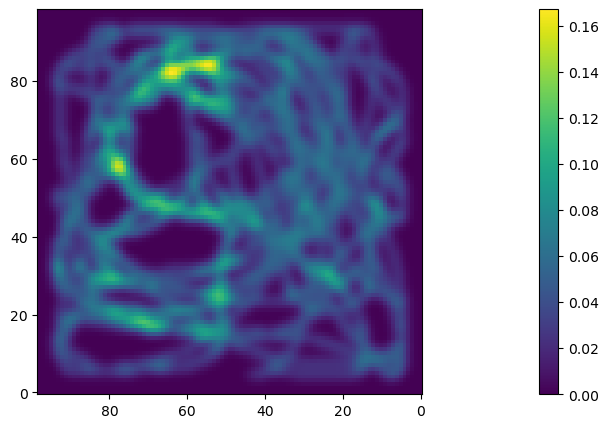

625/625 [==============================] - 4s 6ms/step
1


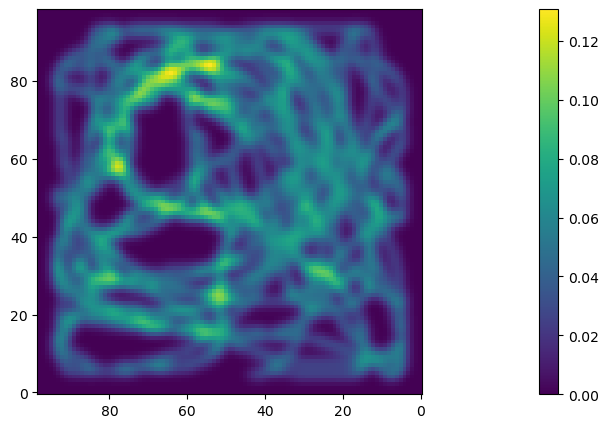

625/625 [==============================] - 3s 5ms/step
2


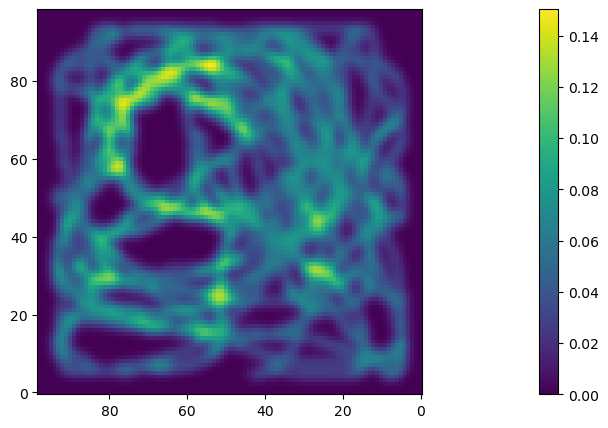

625/625 [==============================] - 4s 6ms/step
3


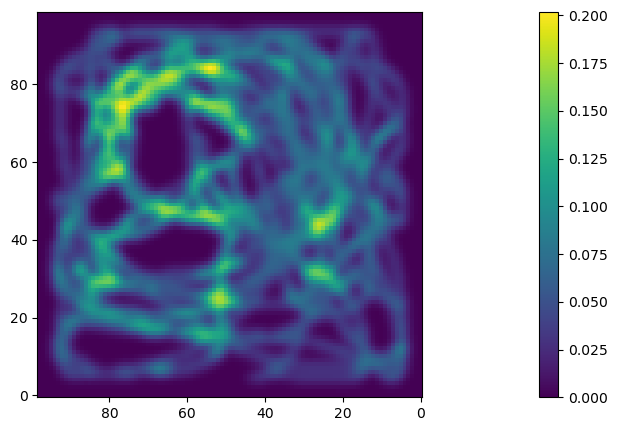

 1407/16000 [=>............................] - ETA: 43s - loss: 0.1101

In [ ]:
# Training with output check in every epoch 

if Retrain:

  opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
  if Retrain_nocat:
    keras.backend.clear_session()
    model_r = model_arch()
    model_r.compile(optimizer=opt, loss = 'mse', )
  else:
    model_r.compile(optimizer=opt, loss = custom_lr_loss, )
  print("Loading weights from previous model")

  model_r.load_weights(fol + old_model_n +".h5")
  model_r.summary() 

  # if Retrain_nocat:
  #   tf.keras.backend.clear_session()
  #   model_r = tf.keras.models.load_model(fol + old_model_n + ".h5", custom_objects = {"GraphConv": GraphConv, "FF":FF})
  #   # opt = tf.keras.optimizers.Adam(learning_rate= lr_schedule)
  #   opt = tf.keras.optimizers.Adam(learning_rate= 0.00001)
  #   model_r.compile(loss = 'mse', optimizer=opt)
  #   model_r.summary() 
  
  for ii in range(retrain_epochs):
    num_images = pos[0]-1
    loss = []
    val_loss = []
    history = model_r.fit(
              [sub_imgs_t[0], sub_pi_t[0]],
              sub_r_t[0],
              epochs = 1,
              batch_size = 1 ,
              validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_r_t[1]),
              shuffle = True)
    
    predicted_r = model_r.predict(comp_data)

    print(ii)  
    ot = predicted_r
    # print(np.sum(reward))
    # print(ot.shape)
    thresh = np.min(ot)*0
    # print(thresh)
    firr = np.nonzero(ot!=thresh)
    # print(firr[0])
    #firr = np.nonzero(abs(resp_neurons[i+num])>thresh)
    firposgrid = pos[firr[0], :]
    # print(firposgrid)
    # title = "pred reward without object"
    firing_map = firing_rate_map(firposgrid, ot, firr, title)
    plt.imshow(firing_map, origin= 'upper')
    firing_map = firing_rate_map(firposgrid, ot, firr, title)
    plt.imshow(firing_map, origin= 'upper')
    plt.colorbar()
    ax=plt.gca()                            # get the axis
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.show()

  model_r.save(fol+ new_model_n +".h5")

  wts = model_r.weights
  # print(wts[-1])

  img_ind = np.where(sub_r_t[0] == 1)

  print('Processing Fisher Information...')
  I_new = computer_fisher(model_r, [sub_imgs_t[0], sub_pi_t[0]], img_ind[0])
  print('Processing Finish!')
  
  New_I = I_new.copy()
  for j in range(len(New_I)):
    if np.amax(New_I[j]) == 0:
      New_I[j] = New_I[j]/(np.amax(New_I[j]) + 0.00001)
    else:
      New_I[j] = New_I[j]/np.amax(New_I[j])
  
  # I_tot = I + I_new
  # I_tot = I_new
  # I_tot = I_new
  # hist_ = history.history

In [ ]:
# New_I = I_new.copy()
# for j in range(len(New_I)):
#   if np.amax(New_I[j]) == 0:
#     New_I[j] = New_I[j]/(np.amax(New_I[j]) + 0.00001)
#   else:
#     New_I[j] = New_I[j]/np.amax(New_I[j])

In [ ]:
# if Retrain:
for i in range(len(I_new)):
  # print(np.amax(New_I[i]))
  # print(np.amax(I_new[i]))
  # print(np.amax(I_new[i]))
  print(I_new[i])
  # print(np.amax(wts[i]))

In [ ]:
if Retrain:
  # I_tot = I + New_I
  I_tot = I_new
  model_dict = {"weights": wts, "fisher": I_tot} #, "history": hist_} 
  with open(fol+"mod_dict_" + new_model_n + ".pk1", 'wb') as ff:
      pickle.dump(model_dict, ff)
      ff.close() 

In [ ]:
# model_r.save(fol+ new_model_n +".h5")

# wts = model_r.weights
# print(wts[-1])

# print('Processing Fisher Information...')
# I = computer_fisher(model_r, [sub_imgs_t[0], sub_pi_t[0]])
# print('Processing Finish!')
# hist_ = history.history

# model_dict = {"weights": wts, "fisher": I, "history": hist_} 
# with open(fol+"mod_dict_" + new_model_n + ".pk1", 'wb') as ff:
#     pickle.dump(model_dict, ff)
#     ff.close() 

In [ ]:
# if Retrain: 
#   if Retrain_nocat:
#     tf.keras.backend.clear_session()
#     model_r = tf.keras.models.load_model(fol + old_model_n + ".h5", custom_objects = {"GraphConv": GraphConv, "FF":FF})
#     opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)
#     model_r.compile(loss='mse', optimizer=opt)
#     model_r.summary() 
  
#   num_images = pos[0]-1
#   loss = []
#   val_loss = []
#   history = model_r.fit(
#             [sub_imgs_t[0], sub_pi_t[0]],
#             sub_r_t[0],
#             epochs = retrain_epochs,
#             batch_size = 16,
#             validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_r_t[1]),
#             shuffle = True)
  
#   # namm = "re_traj(col_obj)(sh3)_newrew_mlpdepth3_bw_20k"  
#   model_r.save(fol+ new_model_n +".h5")

#   wts = model_r.weights
#   print(wts[-1])

#   print('Processing Fisher Information...')
#   I = computer_fisher(model_r, [sub_imgs_t[0], sub_pi_t[0]])
#   print('Processing Finish!')
#   hist_ = history.history

#   model_dict = {"weights": wts, "fisher": I, "history": hist_} 
#   with open(fol+"mod_dict_" + new_model_n + ".pk1", 'wb') as ff:
#       pickle.dump(model_dict, ff)
#       ff.close()

#   # with open(fol+"fisher_" + new_model_n + ".pk1", 'wb') as ff:
#   #     pickle.dump(I, ff)
#   #     ff.close()

#   # # save history
#   # hist_ = history.history
#   # with open(fol+"hist_" + new_model_n + ".pk1", 'wb') as ff:
#   #     pickle.dump(hist_, ff)
#   #     ff.close()

#   kk = str(len(pos))
#   plt.plot(hist_["loss"], "-r", label = "loss")
#   plt.plot(hist_["val_loss"], "--b", label = "val_loss")
#   plt.legend()
#   plt.title("training 2 with objects "+kk)
#   plt.show()
#   # plot_model(regressor_model, to_file=fol+'Max_model1_plot.png', show_shapes=True, show_layer_names=True)

# LAYERWISE OUTPUT ANALYSIS

#### Save & load layerwise output

In [ ]:
# if Analysis: 
  # from keras_gcn import GraphConv 
  # namm = []
# if (not Train) and (not Retrain):
  # namm = new_model_n

tf.keras.backend.clear_session()
autoencoder_model = model_arch()
# autoencoder_model = model_r
autoencoder_model.load_weights(fol+ new_model_n +".h5")
outputs  = [layer.output for layer in autoencoder_model.layers]
# print(namm)
encoded = {}
# encoded['val'] = autoencoder_model.predict([train_imgs, pi_lay])

In [ ]:
# GET OUTPUT FOR THE REQUIRED LAYERS
if pre_conv:
  import keras_bert
  inp = autoencoder_model.input
  layers = ['MEC', 'LEC', 'D1', 'D2', 'D3', 'graph_conv']
  lim = [0.8, 0.8, 0.9, 0.9, 0.9, 0.8, 0.8]
  lay_nam = layers
  # lay_nam = ['MEC', 'LEC', 'rnn_1', 'rnn_2', 'rnn_3', 'graph_conv']

  encoded_pre = {}

  for i in range(len(layers)):
    layer_output = autoencoder_model.get_layer(layers[i]).output
    # layer_output.shape
    functor = K.function(inp, layer_output)
    temp1 = functor(comp_data)
    # print(lay_nam[i]+ " data is calculated.")
    # print(temp1.shape)
    if layers[i] == 'graph_conv':
      encoded_pre['graph_LEC'] = temp1[:,0,:]
      encoded_pre['graph_MEC'] = temp1[:,1,:]
    else:
      encoded_pre[lay_nam[i]] = temp1
  #     print(encoded_pre[lay_nam[i]].shape)
  # print(encoded_pre["graph_LEC"].shape)
  # print(encoded_pre["graph_MEC"].shape)


  from matplotlib.pyplot import close
  # outs = [encoded_pre["MEC"], encoded_pre['LEC'], encoded_pre['rnn_1'], encoded_pre['rnn_2'],  encoded_pre['graph_LEC'], encoded_pre['graph_MEC']]
  # outs = ['MEC', 'LEC', 'rnn_1', 'rnn_2', 'rnn_3', 'graph_LEC', 'graph_MEC']
  outs = lay_nam[:-1] + ['graph_LEC', 'graph_MEC']
  outs_n = lay_nam[:-1] + ["gr_LEC", "gr_MEC"]#, 'CA1']#, "CA1", "CA3"]
  # outs_n = ["MEC", "LEC", 'rnn_1', 'rnn_2', 'rnn_3', "gr_LEC", "gr_MEC"]#, 'CA1']#, "CA1", "CA3"]
  pos_out = pos

  for k in range(len(outs)):
    if outs[k] == 'rnn_1' or 'rnn_2':
      resp_neurons = np.transpose(np.squeeze((encoded_pre[outs[k]])))
    else:
      resp_neurons = np.squeeze(np.transpose(encoded_pre[outs[k]]))
    # print(resp_neurons.shape)
    avg = np.mean(abs(resp_neurons))
    std_dev = np.std(resp_neurons)
    # print(avg)
    # print(std_dev)
    m = np.amax(resp_neurons)
    # print(m)
    num = 0
    for j in range(int(np.divide(len(resp_neurons),50))):
        onm = outs_n[k]
        for i in range(50):
            plt.subplot(7,8,i+1)
            thresh = np.amax(resp_neurons[i+num]) * lim[k]
            # thresh = 0
            # thresh = avg + 2*std_dev
            firr = np.nonzero(resp_neurons[i+num]>thresh)
            firposgrid = pos_out[firr[0], :]
            # plt.scatter(pos[:,0], pos[:,1])
            plt.scatter(firposgrid[:,0], firposgrid[:,1], s = 3, color = 'red', marker='o', zorder = 5)
            if obj_pres:
              for tt in range(len(obj_plot)):
                if tt == len(obj_plot)-1:
                  plt.plot(obj_plot[tt][0], obj_plot[tt][1], 'b')
                else:
                  plt.plot(obj_plot[tt][0], obj_plot[tt][1],'--', 'b')
            else:
              for tt in range(len(obj_plot)):
                plt.plot(obj_plot[tt][0], obj_plot[tt][1],'--', 'b')

            plt.plot(env[0], env[1])
            plt.suptitle('output mesh with obj '+str(num)+ ' to '+str(num+50)+' neurons from '+ onm +' layer, threshold=' +str(lim[k])+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

        num = num + 50
        figure = plt.gcf() # get current figure
        figure.set_size_inches(14, 10)
        plt.savefig(fol + onm + "_" + new_model_n + "_" + str(num), bbox_inches='tight')
        plt.show()
        close()


In [ ]:
plt.rcParams['figure.figsize'] = [30,5]
predicted_r = autoencoder_model.predict(comp_data)
plt.plot(predicted_r, label = 'predicted_r')
plt.plot(reward, label = 'actual_r')
plt.legend()
plt.show()
# plt.plot(np.ndarray.flatten(encoded["val"]))
# # plt.plot(abs(encoded["MEC"][:,2]))
# plt.show()

In [ ]:
#print(gt)
plt.plot(reward)
plt.show()
from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
#ot = predicted_output[1][:,-1,:]
#ot = gt
# ot = np.ndarray.flatten(encoded['val'])
ot = predicted_r
print(np.sum(reward))
print(ot.shape)
thresh = np.min(ot)*0
# print(thresh)
firr = np.nonzero(ot!=thresh)
# print(firr[0])
#firr = np.nonzero(abs(resp_neurons[i+num])>thresh)
firposgrid = pos[firr[0], :]
# print(firposgrid)
title = "pred reward without object"
firing_map = firing_rate_map(firposgrid, ot, firr, title)
plt.imshow(firing_map, origin= 'upper')
plt.colorbar()
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.set_xlim(ax.get_xlim()[::-1])

#### Plotting layer wise output

In [ ]:
if Analysis:
  from matplotlib.pyplot import close
  # lim = 0.5
  outs = [encoded["MEC"], encoded['LEC'], encoded['CA3_LSTM']]#, encoded['CA3']]
  lim = [0.9, 0.9, 0.97]
  outs_n = ["MEC", "LEC", "CA3"]
  pos_out = pos

  for k in range(len(outs)):
      resp_neurons = np.transpose(outs[k])
      avg = np.mean(abs(resp_neurons))
      std_dev = np.std(resp_neurons)
      print(avg)
      print(std_dev)
      m = np.amax(resp_neurons)
      print(m)
      num = 0
      for j in range(int(np.divide(len(resp_neurons),50))):
          onm = outs_n[k]
          for i in range(50):
              plt.subplot(7,8,i+1)
              thresh = np.amax(resp_neurons[i+num]) * lim[k]
              # thresh = 0
              # thresh = avg + 2*std_dev
              firr = np.nonzero(resp_neurons[i+num]>thresh)
              firposgrid = pos_out[firr[0], :]
              # plt.scatter(pos[:,0], pos[:,1])
              plt.scatter(firposgrid[:,0], firposgrid[:,1], s = 1, color = 'red', marker='o', zorder = 5)
              for tt in obj:
                plt.plot(tt[0], tt[1])
              plt.plot(env[0], env[1])
              plt.suptitle('output post-conv with obj '+str(num)+ ' to '+str(num+50)+' neurons from '+ onm +' layer, threshold=' +str(lim[k])+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

          figure = plt.gcf() # get current figure
          figure.set_size_inches(16, 10)
          plt.show()
          close()
          num = num + 50

------------------------------


------------------------------


------------------------------

In [ ]:
from pylab import *
layer_weight = autoencoder_model.get_layer("graph_conv").get_weights()
A = layer_weight[0]
figure(1)
imshow(A)
colorbar()
grid(True)
print(np.count_nonzero(A == 0))

In [ ]:
# plt.rcParams['figure.figsize'] = [30,5]
# plt.rcParams['font.size'] = 20
# plt.plot(encoded["MEC"][:,17])
# plt.plot(reward)
# plt.show()
# close()

In [ ]:
A.reshape(1,2500)
plt.hist(A)
plt.show()